<a href="https://colab.research.google.com/github/appolloford/strong_lensing_simulation/blob/main/Lenstronomy_simulation_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%cd /content
!mkdir pkgs
%cd pkgs
!git clone https://github.com/sibirrer/fastell4py.git
%cd fastell4py
%pip install . --user
%cd ../../
%pip install lenstronomy==1.0.0  # tested with version 1.9.0
%pip install corner schwimmbad

/content
mkdir: cannot create directory ‘pkgs’: File exists
/content/pkgs
Cloning into 'fastell4py'...
remote: Enumerating objects: 75, done.
remote: Total 75 (delta 0), reused 0 (delta 0), pack-reused 75
Unpacking objects: 100% (75/75), done.
/content/pkgs/fastell4py
Processing /content/pkgs/fastell4py
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for fastell4py: filename=fastell4py-0.1.0-cp37-cp37m-linux_x86_64.whl size=205878 sha256=d66a4acaac01150026026914c2fd6ed4dd4f6dade84851fc4d7ef58c7f208f7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-4dw1c0tp/wheels/68/a9/11/1e31066942c7fb7581c9378feac5225bbd6d428297706af07d
Suc

/content
rm: cannot remove 'fastell4py': No such file or directory


In [10]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!mkdir /content/drive/MyDrive/LensingSimData

**Resume from here**

In [12]:
# import of standard python libraries
import os
import time
import corner
from pathlib import Path


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

# import lenstronomy package
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

%matplotlib inline

In [13]:
num_sample = 4
show_img = True
dest_dir = Path("/content/drive/MyDrive/LensingSimData/") if IN_COLAB else Path("LensingSimData")


img_config = {
    'exp_time': 500.,  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
    'numPix': 100,  #  cutout pixel size per axis
    'deltaPix': 0.05,  #  pixel size in arcsec (area per pixel = deltaPix**2)
    'fwhm': 0.005,  # full width at half maximum of PSF
    'sigma_bkg': 0.05,  #  background noise per pixel (Gaussian)
}

In [14]:
def get_lens_bnn_config(params):
    config = {}
    config['gamma_ext'] = np.maximum(np.random.normal(params['gamma_ext_mu'], params['gamma_ext_sigma']), 0)
    config['psi_ext'] = np.random.uniform(0.0, 2.*np.pi)
    config['theta_E'] = np.maximum(np.random.normal(loc=params['theta_E_mu'], scale=params['theta_E_sigma']), 0.1)
    config['gamma'] = np.maximum(np.random.normal(params['gamma_mu'], params['gamma_sigma']), 1.85)
    config['center_x'] = np.random.normal(params['center_mu'], params['center_sigma'])
    config['center_y'] = np.random.normal(params['center_mu'], params['center_sigma'])
    config['e1'] = np.minimum(np.random.normal(params['e_mu'], params['e_sigma']), 0.9)
    config['e2'] = np.minimum(np.random.normal(params['e_mu'], params['e_sigma']), 0.9)
    config['model_list'] = params['model_list']
    return config


def create_lens_model(config):
    kwargs_shear = {
        'gamma_ext': config['gamma_ext'], 
        'psi_ext': config['psi_ext'],
    }  # shear values to the source plane
    kwargs_spemd = {
        'theta_E': config['theta_E'], 
        'gamma': config['gamma'], 
        'center_x': config['center_x'], 
        'center_y': config['center_y'], 
        'e1': config['e1'], 
        'e2': config['e2'],
    }  # parameters of the deflector lens model

    kwargs_maps = {
        'SPEMD': kwargs_spemd,
        'SHEAR_GAMMA_PSI': kwargs_shear,
    }

    # the lens model is a supperposition of an elliptical lens model with external shear
    res = {
        'kwargs_list': [kwargs_maps[key] for key in kwargs_maps],
        'class': LensModel(lens_model_list=config['model_list']),
    }
    return res



def create_light_model(config):
    e1, e2 = param_util.phi_q2_ellipticity(config['phi_G'], config['q'])
    R_sersic = np.random.normal(config['R_sersic_mu'], config['R_sersic_sigma'])
    n_sersic = np.random.normal(config['n_sersic_mu'], config['n_sersic_sigma'])

    kwargs = {
        'amp': config['amp'],
        'R_sersic': R_sersic,
        'n_sersic': n_sersic,
        'e1': e1,
        'e2': e2,
        'center_x': config['center_x'],
        'center_y': config['center_y'],
    }

    res = {
        'kwargs_list': [kwargs],
        'class': LightModel(light_model_list=config['model_list']),
    }
    return res


def get_source_position(params):
    res = {
        'x': np.random.normal(params['position_mu'], params['position_sigma']),
        'y': np.random.normal(params['position_mu'], params['position_sigma']),
    }
    return res


def create_point_source_model(lens_model, source_position, img_config):
    lensEquationSolver = LensEquationSolver(lens_model['class'])
    x_image, y_image = lensEquationSolver.findBrightImage(
        source_position['x'], 
        source_position['y'], 
        lens_model['kwargs_list'], 
        numImages = 4,
        min_distance = img_config['deltaPix'], 
        search_window = img_config['numPix'] * img_config['deltaPix'],
    )
    mag = lens_model['class'].magnification(x_image, y_image, kwargs=lens_model['kwargs_list'])

    # quasar point source position in the source plane and intrinsic brightness
    kwargs = {
        'ra_image': x_image, 
        'dec_image': y_image,
        'point_amp': np.abs(mag) * 1000,
    }  
    point_source_class = PointSource(
        point_source_type_list=['LENSED_POSITION'], 
        fixed_magnification_list=[False],
    )

    res = {
        'kwargs_list': [kwargs],
        'class': point_source_class,
    }
    return res


def plot_image(img):
    cmap_string = 'gray'
    cmap = plt.get_cmap(cmap_string)
    cmap.set_bad(color='k', alpha=1.)
    cmap.set_under('k')

    v_min = -4
    v_max = 2

    f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
    ax = axes
    im = ax.matshow(np.log10(img), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.autoscale(False)
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

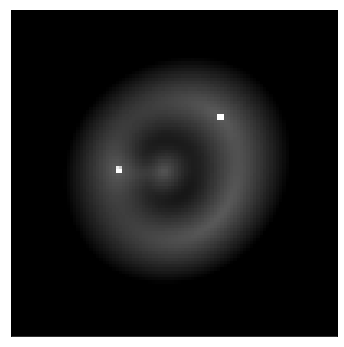

 25%|██▌       | 1/4 [00:00<00:00,  6.18it/s]

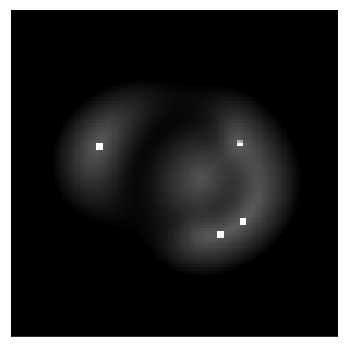

 50%|█████     | 2/4 [00:00<00:00,  6.05it/s]

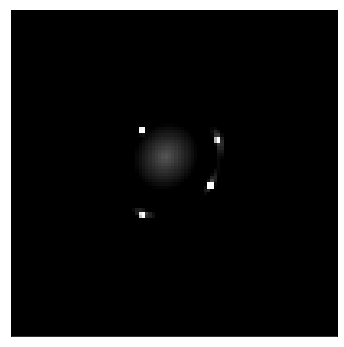

 75%|███████▌  | 3/4 [00:00<00:00,  5.74it/s]

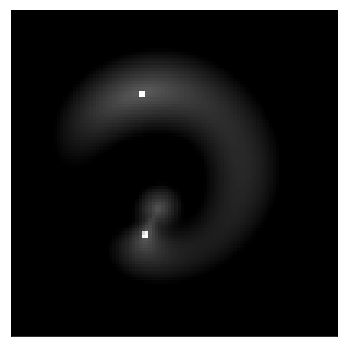

100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

['img_path' 'theta_E' 'gamma' 'center_x' 'center_y' 'e1' 'e2' 'gamma_ext'
 'psi_ext' 'source_x' 'source_y' 'source_n_sersic' 'source_R_sersic'
 'sersic_source_e1' 'sersic_source_e2' 'lens_light_e1' 'lens_light_e2'
 'lens_light_n_sersic' 'lens_light_R_sersic']


In [20]:
meta_keys = ['img_path', 
    'theta_E', 'gamma', 'center_x', 'center_y', 'e1', 'e2', 'gamma_ext', 'psi_ext', 
    'source_x', 'source_y', 'source_n_sersic', 'source_R_sersic', 'sersic_source_e1', 'sersic_source_e2', 
    'lens_light_e1', 'lens_light_e2', 'lens_light_n_sersic', 'lens_light_R_sersic']
meta_df = {key: np.zeros(num_sample) for key in meta_keys}
meta_df['img_path'] = ['placeholder'] * num_sample

for i in tqdm(range(num_sample)):

    # Generate the coordinate grid and image properties kwargs
    kwargs_data = sim_util.data_configure_simple(
        img_config['numPix'], 
        img_config['deltaPix'], 
        img_config['exp_time'], 
        img_config['sigma_bkg'],
    )
    image_data_class = ImageData(**kwargs_data)

    kwargs_psf = {
        'psf_type': 'GAUSSIAN', 
        'fwhm': img_config['fwhm'], 
        'pixel_size': img_config['deltaPix'], 
        'truncation': 3,
    }
    psf_class = PSF(**kwargs_psf)


    # Mean of the BNN prior: mass distribution for the lens system (all kinds of mass: dm halo + galaxy )
    lens_bnn_config_params = {
        'gamma_ext_mu': 0.015, 
        'gamma_ext_sigma': 0.005, 
        'theta_E_mu': 1.25, 
        'theta_E_sigma': 0.4, 
        'gamma_mu': 2.0, 
        'gamma_sigma': 0.05, 
        'center_mu': 0.0, 
        'center_sigma': 0.2, 
        'e_mu': 0.0,
        'e_sigma': 0.2,
        'model_list': ['SPEMD', 'SHEAR_GAMMA_PSI'],

    }
    lens_bnn_config = get_lens_bnn_config(lens_bnn_config_params)
    lens_model = create_lens_model(lens_bnn_config)


    # lens light model
    lens_light_config = {
        'phi_G': 0.9,
        'q': 0.9,
        'R_sersic_mu': 0.3,
        'R_sersic_sigma': 0.1,
        'n_sersic_mu': 1.0,
        'n_sersic_sigma': 0.1,
        'amp': 0.8,
        'center_x': lens_bnn_config['center_x'],  # taken from lens
        'center_y': lens_bnn_config['center_y'],  # taken from lens
        'model_list': ['SERSIC_ELLIPSE'],
    }
    lens_light_model = create_light_model(lens_light_config)


    source_position_params = {
        'position_mu': 0.0,
        'position_sigma': 0.1,
    }
    source_position = get_source_position(source_position_params)



    # source light model
    source_sersic_config = {
        'phi_G': 0.5,
        'q': 0.8,
        'R_sersic_mu': 0.2,
        'R_sersic_sigma': 0.1,
        'n_sersic_mu': 1.0,
        'n_sersic_sigma': 0.1,
        'amp': 1.2,
        'center_x': source_position['x'],
        'center_y': source_position['y'],
        'model_list': ['SERSIC_ELLIPSE'],
    }
    source_model = create_light_model(source_sersic_config)


    # quasar point source model
    point_source_model = create_point_source_model(lens_model, source_position, img_config)


    # not sure what this is for
    kwargs_numerics = {'supersampling_factor': 1}


    imageModel = ImageModel(
        image_data_class, 
        psf_class, 
        lens_model['class'], 
        source_model['class'],
        lens_light_model['class'], 
        point_source_model['class'], 
        kwargs_numerics = kwargs_numerics,
    )


    # generate image
    img = imageModel.image(
        lens_model['kwargs_list'], 
        source_model['kwargs_list'], 
        lens_light_model['kwargs_list'], 
        point_source_model['kwargs_list'],
    )
    #poisson = image_util.add_poisson(img, exp_time=exp_time)
    #bkg = image_util.add_background(img, sigma_bkd=sigma_bkg)
    img = img  # + bkg + poisson

    image_data_class.update_data(img)
    kwargs_data['image_data'] = img


    # visualize images
    if show_img == True:
        plot_image(img)


    # save image file
    img_path = os.path.join(dest_dir, 'X_{0:07d}.npy'.format(i))  # changed to 0-index
    np.save(img_path, img)


    # fill in meta_df
    meta_df['img_path'][i] = img_path
    
    # lens keys
    _lens_dict = {
        **lens_model['kwargs_list'][0],
        **lens_model['kwargs_list'][1],
    }
    for key in ['theta_E', 'gamma', 'center_x', 'center_y', 'e1', 'e2', 'gamma_ext', 'psi_ext']:
        meta_df[key][i] = _lens_dict[key]
    
    # source keys
    _source_dict = source_model['kwargs_list'][0]
    meta_df['source_x'][i] = _source_dict['center_x']
    meta_df['source_y'][i] = _source_dict['center_y']
    meta_df['source_n_sersic'][i] = _source_dict['n_sersic']
    meta_df['source_R_sersic'][i] = _source_dict['R_sersic']
    meta_df['sersic_source_e1'][i] = _source_dict['e1']
    meta_df['sersic_source_e2'][i] = _source_dict['e2']

    # lens light keys
    _lens_lights_dict = lens_light_model['kwargs_list'][0]
    meta_df['lens_light_e1'][i] = _lens_lights_dict['e1']
    meta_df['lens_light_e2'][i] = _lens_lights_dict['e2']
    meta_df['lens_light_n_sersic'][i] = _lens_lights_dict['n_sersic']
    meta_df['lens_light_R_sersic'][i] = _lens_lights_dict['R_sersic']


# save meta data df as csv
meta_df = pd.DataFrame.from_dict(meta_df)
meta_path = os.path.join(dest_dir, 'metadata.csv')
meta_df.to_csv(meta_path, index=None)

print(meta_df.columns.values)